# Beat Saber - Generated Maps Algorythmically, Mostly For Fun, No Profit

There is this [Beat Sage](https://beatsage.com/) map generator powered by AI that seems to be working well. The results looks fun.

Still, I was curious to see if it would be possible to generate maps through probabilities, based on observed patterns from existing maps.

The strategy was to take existing maps, break them into sequences (2 beats per sequence seems like a good balance), take note of which sequence follows which ones, and then randomly generate new maps based on these known patterns.

That worked well, but it felt a bit random and didn't really follow the intensity of the songs I tried it on. When the whole song has about the same intensity level, it doesn't matter, but not for the ones with a drop.

Compared to the Beat Sage AI backed generator, I don't really control what are the potential sequences I am getting at what point in the song, so I kind of have to do my best with what I have.

The following code demonstrates the approach I took. and given that it fits in 23 short blocks of code, and isn't requiring a great amount of GPU processing, I think it's fine for the fun I can get with the result.

In this example, I will use maps created by [Dee-Dee](https://bsaber.com/members/dee-dee/), [Nixie.Korten](https://bsaber.com/members/Nixie.Korten/) and [misterlihao](https://bsaber.com/members/misterlihao/), mainly because their maps tend to have a nice flow. The results will tend to be quite different depending on the tracks that are used for the training. Going all in with all the custom tracks I might have on my computer produced too much randomness, so targeting on a specific style seems to work better.


This notebook generates a map for the song [Big In Japan by Alphaville](https://www.youtube.com/embed/_IYjBCLKmBE). This first version was without the automatic lighting effects.

I also rendered a map for `Maria [I Like It Loud]` by Scooter after adding automatic lighting capabilities. The result can be seen on [Youtube](https://youtu.be/iQaO4YG7Su0)

## How to use this code

[Beastsaber has excellent instructions](https://bsaber.com/getting-started/mapping/) explaining how to prepare an audio file for mapping.

At a high level, the following steps are necessary:
1. Software Setup: Download the necessary tools for mapping: an [audio editor](https://www.audacityteam.org/) and a [map editor](https://bsmg.wiki/mapping/#map-editing-resources).
2. Audio Setup: [Set up your audio file](https://bsmg.wiki/mapping/basic-audio.html), find and confirm the BPM, and export in OGG format.
    * Adding 8 full beat before the song starts gives some time to see the first blocks comming
   
3. Editor Setup & Mapping: Set up your song in your [mapping editor](https://bsmg.wiki/mapping/#community-editors) (we recommend MMA2) and get mapping! Review [basic mapping practices](https://bsmg.wiki/mapping/basic-mapping.html) before you start. [Playtest](https://bsmg.wiki/mapping/#playtesting) your own work early and often.

<- This is where we can insert ourselves in the creation process

4. Lighting: Review [basic lighting information](https://bsmg.wiki/mapping/#lighting-practices). Simple manual lighting is easier than you think!
5. ~Playtesting: Third-party playtesting via the BSMG Discord is highly recommended to get constructive feedback and to get past your own “map blindness.~
6. ~Release Your  Map: Once your song has been mapped, lighted, and playtested you’re ready to release your song to the world on BeatSaver (it will mirror here to BeastSaber in a few minutes).~

^ About the two last steps: the result will be quite random, and not worthy of standing along all the great work from real mappers. 

In [1]:
import json
import random
from os.path import exists
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

import math
import soundfile as sf

## Configuration

Location of the customeLevels and WIP levels, as well as the difficulty used for training

In [2]:
customLevels_folder = "/mnt/c/Program Files/Oculus/Software/Software/hyperbolic-magnetism-beat-saber/Beat Saber_Data/CustomLevels/"
customWIPLevels_folder = "/mnt/c/Program Files/Oculus/Software/Software/hyperbolic-magnetism-beat-saber/Beat Saber_Data/CustomWIPLevels"
difficulty = "ExpertStandard.dat"


assert exists(customLevels_folder) == True, f"customLevels folder {customLevels_folder} should exists"
assert exists(customWIPLevels_folder) == True, f"customWIPLevels folder {customWIPLevels_folder} should exists"

## Songs used for training

For this, I am searching for folders in the customeLevels folder, and uses any song matching one of listed keywords

In [3]:
filters = ["dee", "nixie", "misterlihao"]

notes_files = [
    x for x in os.listdir(customLevels_folder)
    if any(y in x.lower() for y in filters)
]

print('Number of songs used for training:', len(notes_files))
notes_files

Number of songs used for training: 31


['1a0b9 (Lone Digger - Nixie.Korten)',
 '1a0be (Wonderland - Nixie.Korten)',
 '1f5a3 (もーいいかい - misterlihao)',
 '1f767 (アリスブルー - misterlihao)',
 '205d1 (くうになる - misterlihao)',
 '20ac4 (About You - DeeDee)',
 '20ac8 (Pepas - Dee-Dee)',
 '21307 (ただ声一つ - misterlihao)',
 '21333 (全部君のせいだ - misterlihao)',
 '21979 (フクロウさん - misterlihao)',
 '22846 (バニー - misterlihao)',
 '22e63 ( - misterlihao)',
 '240f4 (Loco - Dee-Dee)',
 '24829 (まってるよ - misterlihao)',
 '24b52 (今日とまだバイバイしたくないの - misterlihao)',
 '24f18 (和音 - misterlihao)',
 '250af (うらたねこ♀ - misterlihao)',
 '2528b (おにけもだんす - misterlihao)',
 '25306 (AHAREN HEART - misterlihao)',
 '254a8 (感情ディシーブ - misterlihao)',
 '25a6b (Supersonic - Dee-Dee)',
 '260d1 (えすけーぷ - misterlihao)',
 '270ed (WOW BB - DeeDee)',
 '271da (All Night - Nixie.Korten)',
 '271db (Bom Bom - Nixie.Korten)',
 '271df (Perfume - Nixie.Korten)',
 '271e0 (Light Up The Night - Nixie.Korten)',
 '271e1 (Mr Magpie - Nixie.Korten)',
 '271e4 (Wake Up Romeo - Nixie.Korten)',
 '27593 (推し変なんて

## Output file configuration

In [4]:
# MODIFY ME
song_output_folder = "Alphaville - Big In Japan - 97.79"

first_beat = 16
last_beat = 368

In [5]:
# probably ok to leave me unmodified

# uses two beats for one sequence of blocks
# longer sequences (ex.: 4) reduces the randomness since it reduces the potential possibility of 
# chaining sequences
sequence_length = 2 

# precision: break each beat in 8 parts. 1/8 of a beat. necessary for fast songs. 
# having this too low could cause block overlay
precision = 8 

## Confirming configurations

In [6]:
output_file = "{}/{}/{}".format(customWIPLevels_folder, song_output_folder, difficulty)
output_info_dat_file = "{}/{}/Info.dat".format(customWIPLevels_folder, song_output_folder)
assert exists(output_info_dat_file), f"info file should exists in the song_output_folder" 
assert exists(output_file), f"output file {song_output_folder}/{difficulty} should exist"

with open(output_info_dat_file) as f:
    info_dat = json.load(f)
    song_key = "_songFilename"
    bpm_key = "_beatsPerMinute"
    song_file_key = "_songFilename"
    song_file_name = info_dat[song_file_key]
    audio_file = "{}/{}/{}".format(customWIPLevels_folder, song_output_folder, song_file_name)

# print("* checking that the song file exists in the song_output_folder")
assert exists(audio_file), f"song file {info_dat[song_file_key]} should exist"

# print("* checking that the _beatsPerMinute value is configured")
assert bpm_key in info_dat.keys(), f"key {bpm_key} should be in info_dat.keys(): {bpm_key in info_dat.keys()}"
assert info_dat["_beatsPerMinute"] > 0.0, f"{bpm_key} should have a value greater than zero: {info_dat[bpm_key]}"

# the info.dat file looks like this
info_dat

{'_version': '2.0.0',
 '_songName': 'Big In Japan',
 '_songSubName': '',
 '_songAuthorName': 'Alphaville',
 '_levelAuthorName': 'unknow',
 '_beatsPerMinute': 97.79000091552734,
 '_shuffle': 0,
 '_shufflePeriod': 0.5,
 '_previewStartTime': 12,
 '_previewDuration': 10,
 '_songFilename': 'song.ogg',
 '_coverImageFilename': 'cover.jpg',
 '_environmentName': 'PanicEnvironment',
 '_songTimeOffset': 0,
 '_customData': {'_contributors': [],
  '_editors': {'MMA2': {'version': '4.8.4'}, '_lastEditedBy': 'MMA2'}},
 '_difficultyBeatmapSets': [{'_beatmapCharacteristicName': 'Standard',
   '_difficultyBeatmaps': [{'_difficulty': 'Expert',
     '_difficultyRank': 7,
     '_beatmapFilename': 'ExpertStandard.dat',
     '_noteJumpMovementSpeed': 16,
     '_noteJumpStartBeatOffset': 0,
     '_customData': {'_editorOffset': 0,
      '_editorOldOffset': 0,
      '_warnings': [],
      '_information': [],
      '_suggestions': [],
      '_requirements': []}}]}]}

## How Blocks Are Encoded

ExpertStandard.dat is a JSON file, and contains multiple sections. The one that is interesting is the "_notes" section, which contains a long series of entries like the folowing:

In [7]:
sample_block = {
  "_time" : 25.5,
  "_lineIndex" : 3,
  "_lineLayer" : 1,
  "_type" : 1,
  "_cutDirection" : 0
}

The `_time` key identifies the beat where that specific entry will show up.

The following lines are a bit more cryptic, but here is a lookup table, and with which charactor I translate them when I flatten each block for processing.


Columns. translated by the idx directly
* _lineIndex: 0 "far left column"
* _lineIndex: 1 "center left column"
* _lineIndex: 2 "center right column"
* _lineIndex: 3 "far right column"

Layer. translated by the first column of letters on my keyboard
* _lineLayer: 0 "bottom" "z"
* _lineLayer: 1 "middle" "a"
* _lineLayer: 2 "top" "q"

Block type. 
* _type: 0 "red" "r"
* _type: 1 "blue" "b"
* _type: 3 "bomb" "x"

Cut Direction. I don't have a numeric keypad on my keyboard, so I used the left secton to represent them.
* _cutDirection: 0 "up" w
* _cutDirection: 1 "down" x
* _cutDirection: 2 "left" a
* _cutDirection: 3 "right" d
* _cutDirection: 4 "up left"  q
* _cutDirection: 5 "up right" e
* _cutDirection: 6 "down left" z
* _cutDirection: 7 "down right" c
* _cutDirection: 8 "all" s


## How Lighting is encoded

The lighting track (`_events` key in the ExpertStandard.dat JSON file) is a lot more complex than the `_notes` track.

A single lighting event looks like this:

In [8]:
sample_light = {
    "_time": 52.5,
    "_type": 1,
    "_value": 5,
}

The pairs of `_type` and `_value` maps to specific conditions, which looks like this

![beat_saber_lighting_track.png](attachment:beat_saber_lighting_track.png)

A major difference with the blocks is that some of these lights are toggles. They will go on, and stay on until they are turned off, which makes it harder train on since a certain light might be turned off a few sequences later, completely out of context with when it was activated.

## Function that translates the nodes into a pattern string

In [9]:
layer = "zaq"
colour = "rb?x"
cut_dir = "wxadqezcs"

lighting_type = "abcdefghijklmnopqrstuvwxyz1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZ"
lighting_value = "abcdefghijklmnopqrstuvwxyz1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# def encode_block(note):
#     try:
#         return str(note["_lineIndex"]) + layer[note["_lineLayer"]] + colour[note["_type"]] + cut_dir[note["_cutDirection"]]
#     except:
#         print(note)
#         raise

def encode_block(note, light):
    seq = (
        str(note["_lineIndex"]) 
        + layer[note["_lineLayer"]] 
        + colour[note["_type"]] 
        + cut_dir[note["_cutDirection"]]
    )

    if light != False:
        seq = seq + lighting_type[light['_type']] + lighting_value[light['_value']]
    else:
        seq = seq + lighting_type[random.randint(0,5)] + lighting_value[0]
    
    return seq

def decode_pattern(base, precision, seq):
    seqs = json.loads(seq)
    outputs = [] 
    
    for i in range(len(seqs)):
        for j in range(len(seqs[i])):
            outputs.append({
                "_time": base+(i/precision),
                "_lineIndex": int(seqs[i][j][0]),
                "_lineLayer": layer.index(seqs[i][j][1]),
                "_type": colour.index(seqs[i][j][2]),
                "_cutDirection":  cut_dir.index(seqs[i][j][3])            
            })
    return outputs

def decode_lighting(base, precision, seq):
    seqs = json.loads(seq)
    lights = []
    
    for i in range(len(seqs)):
        for j in range(len(seqs[i])):
            lights.append({
                "_time": base+(i/precision),
                "_type": lighting_type.index(seqs[i][j][4]),
                "_value": lighting_value.index(seqs[i][j][5])
            })
    return lights

assert encode_block(sample_block, sample_light) == "3abwbf", f"the output from encoding isn't matching expectations"
assert json.dumps(decode_pattern(sample_block['_time'], precision, '[["3abwbf"]]')) == json.dumps([sample_block]), f"decoded pattern isn't matching the original block"
assert json.dumps(decode_lighting(sample_light['_time'], precision, '[["3abwbf"]]')) == json.dumps([sample_light]), f"decoded pattern isn't matching the original block"


## Training functions

In [10]:
# received a track sequence, non encoded in json, returns the last part encoded in a json string
def extract_last_pattern(seq, sequence_length, precision):
    return json.dumps(seq[-(sequence_length * precision):])

def remember_patterns(track, sequence_length, precision):
    global following
    
    previous_pattern = ""
    previous_end = ""

    for i in range(len(track)):
        current_pattern = json.dumps(track[i])    
        if previous_pattern not in following.keys():
            following[previous_pattern] = []

        following[previous_pattern].append(current_pattern)     
        previous_pattern = current_pattern 
        
        
        current_end = json.dumps(track[i][-precision:])
        previous_end = current_end 

def give_me_following(full_encoded_seq, sequence_length, precision):
    decoded_seq = json.loads(full_encoded_seq)
    
    last_pattern = extract_last_pattern(decoded_seq, sequence_length, precision)
    
    return last_pattern

## File processing functions

In [11]:
def read_track_file(base_folder, song_output_folder, difficulty_file):
    filename = "{}/{}/{}".format(base_folder, song_output_folder, difficulty_file)
    
    if exists(filename):
        with open(filename) as f:
            return json.load(f)
    
    print("File '{}/{}' not found. skipping folder".format(song_output_folder, difficulty_file))
    return False

def find_lighting_for_note(lightings, t):
    for event in lightings:
        if event['_time'] > t:
            return False
        elif event['_time'] == t:
            return event
    
    return False

def convert_json_to_patterns(file, sequence_length, precision, content):
    if "_notes" not in content.keys() or "_events" not in content.keys():
        print("* this is a new song:", file)
        print(content.keys())
        return False
    
    first_note = math.floor(content["_notes"][0]["_time"])
    last_note = content["_notes"][-1]["_time"]
    
    nb_sequence = int(((last_note - first_note)) / sequence_length)+1
    
    print("file: {}, first_note: {}, last_note: {}, precision: {}, nb_sequences: {}".format(
        file, first_note, last_note, precision, nb_sequence
    ))
    
    # initializing an empty list that will keep track of the notes
    track = [[[] for y in range(sequence_length * precision)] for x in range(int(nb_sequence))]
    
    for note, block in enumerate(content["_notes"]):
        index = int(block["_time"])
        subindex = int((block["_time"] - index) * precision)
        idx = (index - first_note) * precision + subindex
        seq = idx//(sequence_length*precision)
        pos = idx%(sequence_length*precision)

        encoded = encode_block(block, find_lighting_for_note(content["_events"], block["_time"]))
        try:
            track[seq][pos].append(encoded)
        except:
            print(filename, note, seq, pos, idx, block)
            raise
            
    return track
        

def process_file(folder, file, difficulty, precision, sequence_length):
    notes_json = read_track_file(folder, file, difficulty)
    
    if notes_json != False:
        track = convert_json_to_patterns(file, sequence_length, precision, notes_json)        
        
        if track != False:
            remember_patterns(track, sequence_length, precision)

## Song processing

This section goes through all training files and register transitions in the `following` global variable.

In [12]:
following = {}

for file in notes_files:
    process_file(customLevels_folder, file, difficulty, precision, sequence_length)

file: 1a0b9 (Lone Digger - Nixie.Korten), first_note: 4, last_note: 347.5, precision: 8, nb_sequences: 172
file: 1a0be (Wonderland - Nixie.Korten), first_note: 15, last_note: 323.25, precision: 8, nb_sequences: 155
file: 1f5a3 (もーいいかい - misterlihao), first_note: 8, last_note: 317.5, precision: 8, nb_sequences: 155
file: 1f767 (アリスブルー - misterlihao), first_note: 8, last_note: 534, precision: 8, nb_sequences: 264
file: 205d1 (くうになる - misterlihao), first_note: 6, last_note: 422, precision: 8, nb_sequences: 209
file: 20ac4 (About You - DeeDee), first_note: 3, last_note: 367, precision: 8, nb_sequences: 183
file: 20ac8 (Pepas - Dee-Dee), first_note: 5, last_note: 613, precision: 8, nb_sequences: 305
file: 21307 (ただ声一つ - misterlihao), first_note: 8, last_note: 335.5, precision: 8, nb_sequences: 164
file: 21333 (全部君のせいだ - misterlihao), first_note: 8, last_note: 551, precision: 8, nb_sequences: 272
file: 21979 (フクロウさん - misterlihao), first_note: 20, last_note: 483, precision: 8, nb_sequences: 

## Audio File Analysis

This sections is an attempt to naively detect variations in the song. Using these variations, we can compare them against potential following sequences of blocks, and see which one might be a better fit given the density of the noise.

In [13]:
audio_file_wav = audio_file + ".wav"

data, samplerate = sf.read(audio_file)
if not exists(audio_file_wav):
    sf.write(audio_file_wav, data, samplerate)

Fs, aud = wavfile.read(audio_file_wav)

# once the audio file is processed, we don't need the wave file anymore.
if exists(audio_file_wav):
    os.remove(audio_file_wav)

In [14]:
song_bpm = info_dat["_beatsPerMinute"]
song_bps = song_bpm/60
song_spb = 60/song_bpm
sample_per_beat = int(Fs * song_spb)

print(f"Folder: {song_output_folder}\nfile: {song_file_name}\nbpm: {song_bpm}\nbps: {song_bps}\nseconds per beat: {song_spb}\naudio samples per beat: {sample_per_beat}")

Folder: Alphaville - Big In Japan - 97.79
file: song.ogg
bpm: 97.79000091552734
bps: 1.6298333485921224
seconds per beat: 0.6135596629335244
audio samples per beat: 27057


## spectogram of the left channel

/home/simon/.virtualenvs/py38/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


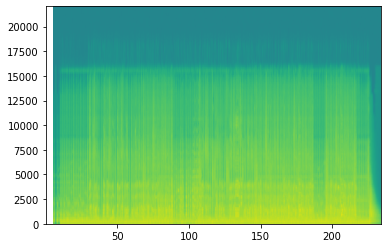

In [15]:
aud_left = aud[:,0] # select left channel only

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(aud_left, Fs=Fs)
plt.show()

In [17]:
positive_aud_left = [abs(x) for x in aud_left]

range3 = max(positive_aud_left)
range0 = range3 / 10

break_down = []

for beat in range(int(len(positive_aud_left)/sample_per_beat)):
    for p in range(precision):
        boundary_left = int((beat * sample_per_beat) + (p * (sample_per_beat/precision)))
        boundary_right = int(boundary_left + ((p+1) * (sample_per_beat/precision)))
        
        noise_left = int(np.mean(positive_aud_left[boundary_left:boundary_right]))

        break_down.append(int(noise_left//range0))

In [18]:
print(range0, range3) 

2665.8 26658


In [19]:
print(first_beat, last_beat)
trimmed_intensity = break_down[(first_beat)*precision:]

16 368


In [20]:
print('beginning...')
print(break_down[:first_beat*(precision)], '*', break_down[first_beat*precision:(first_beat*sequence_length*precision)])
print('...end')
print(break_down[-(last_beat*precision):last_beat], '*', break_down[-last_beat:])

beginning...
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] * [2, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 3, 1, 0, 0, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1]
...end
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 

## Selecting the best sequence candidate compared to the song intensity

The method used is trying to generate collisions between the audio intensity and potential candidates. The higher the number of collisions, the more likely the intensity should match.

Here is an example of audio intensity calculated earlier.
`[3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2]`

The candidate sequences are converted in number of blocks per step. One block = 1, 2 blocks (blue or red) = 2, etc.
```
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
[1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0]
[1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0]
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
[1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
```

By multiplying one array by the other, and calculating the sum of the results, we can get a score value. The higher the score, the better it should match.

Here are two examples:

In [21]:
audio_sequence = [3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2]
bad_candidate = [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
best_candidate = [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
good_candidate = [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

def test_selection(audio_sequence, candidate):
    a = np.array(audio_sequence)
    c = np.array(candidate)
    r = a * c
    print('audio intensity:', a)
    print('* candidate:', c)
    print('* multiplication result:', r)
    print('* sum of the results (score):', sum(r))


test_selection(audio_sequence, bad_candidate)
test_selection(audio_sequence, good_candidate)
test_selection(audio_sequence, best_candidate)
    

audio intensity: [3 4 2 2 2 2 2 2 2 2 2 3 3 3 2 2]
* candidate: [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
* multiplication result: [3 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
* sum of the results (score): 5
audio intensity: [3 4 2 2 2 2 2 2 2 2 2 3 3 3 2 2]
* candidate: [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
* multiplication result: [6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
* sum of the results (score): 6
audio intensity: [3 4 2 2 2 2 2 2 2 2 2 3 3 3 2 2]
* candidate: [1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0]
* multiplication result: [3 0 0 0 2 0 2 0 0 0 2 0 0 0 2 0]
* sum of the results (score): 11


In [22]:
def select(array, audio_sample):
    best_fits = []
    
    np_audio_sample = np.array(audio_sample)
    
    for i, a in enumerate(array):    
        decoded = json.loads(a)
        candidates = np.array([len(x) for x in decoded])

        score = candidates[:len(np_audio_sample)] * np_audio_sample
        best_fits.append(sum(score))

    election = [i for i in range(len(best_fits)) if best_fits[i] == max(best_fits)]
    selected = array[random.choice(election)]

    if False:
        print(audio_sample)
        print(election)
        print(len(array), max(best_fits), len(candidates), 'selected:', selected)
    
    return random.choice(array)  

## generating the sequence of blocks for the song.

This is where we generate the sequence of blocks.

The `base` is the `first_beat`, and it will continue to select sequences of blocks until it reaches the `last_beat`.
These two variables are defined at the top of the notebook, and need to be configured manually. They can be found by matching the beats to the audio in Mediocre Map Assistant 2 (MMA2). Since the loop generates sequences of `sequence_length` (normally 2 beats), it might be necessary to manually add or delete blocks at the end.

The loop starts by setting the `current_pattern` to blank, the code will select the opening sequences (based on the training songs) that better matches the current audio intensity.

The selected sequence will be checked against potential following sequences (variable `following` trained earlier). If somehow there is no known following sequence to the current_pattern, then the code will recover by selecting a new pattern from the opening ones.

In [23]:
base = first_beat

current_pattern = ""
new_track = []
new_lights = []
random.seed(42)

beat = 0
while base < last_beat:    
    l = beat * precision * sequence_length
    r = (beat+1) * precision * sequence_length
    audio_sample = trimmed_intensity[l:r]

    if current_pattern in following.keys():
        pattern = select(following[current_pattern], audio_sample)
    else:
        pattern = select(following[""], audio_sample)
        
    decoded = decode_pattern(base, precision, pattern)
    new_track = new_track + decoded
    
    decoded_light = decode_lighting(base, precision, pattern)
    new_lights = new_lights + decoded_light
    
    current_pattern = give_me_following(pattern, sequence_length, precision)

    base += sequence_length
    beat+=1

## saving the generated sequence in the output track file.

If it crashes here because the output file does not exists, you might need to generate it by added on random block to the level in MMA2, then save. The file isn't created until something is added to it.

In [24]:
with open(output_file) as f:
    output_song = json.load(f)

output_song["_notes"] = new_track
output_song["_events"] = new_lights

with open(output_file, 'w') as f:
    f.write(json.dumps(output_song))

## Conclusion

With the initial version of the code, I generated this mapping for [Big In Japan by Alphaville](https://youtu.be/_IYjBCLKmBE). That virst version was not adding lighting effects.

The code in this notebook was also used to generate a mapping for [Maria (I Like It Loud) by Scooter](https://www.youtube.com/watch?v=iQaO4YG7Su0), but his time with lighting effects.

Obviously it will never match the quality of a talented mapper. Still, it's playable. More than everything, it was fun to code.